In [200]:
# Imports
from tensorflow import keras
import numpy as np

## Investigating constant features and regularization

We first look at the trained Lindel model and investigate the effect of regularization. We focus on the deletion model, since that is the one with most features (3033), and the largest number of weights to train.

In [201]:
# Load Lindel model weights: deletion
model_del_l1 = keras.models.load_model("../data/L1_del.h5")
model_del_l2 = keras.models.load_model("../data/L2_del.h5")

In [202]:
# Get model weights
weights_del_l1, bias_del_l1 = model_del_l1.get_weights()[0], model_del_l1.get_weights()[1]
weights_del_l2, bias_del_l2 = model_del_l2.get_weights()[0], model_del_l2.get_weights()[1]

We take a first look at how features are regularized. We use a naive approach, and we consider that a feature is regularized if all 536 weights (in absolute value) associated with it are less than a given tolerance. 

In [203]:
# Print shape of weights
# Rows are features and columns are classes
print("Shape of weights array:", weights_del_l1.shape)

def count_regularized_features(weights, tolerance=1e-3):
    num_regularized_features = 0
    indices_regularized_features = []
    
    # Iterate over rows (features)
    for i, feature in enumerate(weights):
        # Keep track whether all weights in this row are close to 0
        all_zero = True
    
        # For each feature, iterate over its contributions to each label
        for label in feature:
            if abs(label) > tolerance:
                all_zero = False
            
        if all_zero: 
            num_regularized_features += 1
            indices_regularized_features.append(i)
    
    return num_regularized_features, indices_regularized_features

n = len(weights_del_l1)

# Print weights close to 0
print("\n--- L1")
num_regularized_features_l1, indices_regularized_features_l1 = count_regularized_features(weights_del_l1)
print("Percentage of regularized features with tolerance 1e-3:", 100 * float(num_regularized_features_l1) / n, "%")

print("\n--- L2")
num_regularized_features_l2, indices_regularized_features_l2 = count_regularized_features(weights_del_l2)
print("Percentage of regularized features with tolerance 1e-3:", 100 * float(num_regularized_features_l2) / n, "%")

print("Number of common regularized_features:", 
      len(set(indices_regularized_features_l2).intersection(indices_regularized_features_l1)))

Shape of weights array: (3033, 536)

--- L1
Percentage of regularized features with tolerance 1e-3: 15.2324431256182 %

--- L2
Percentage of regularized features with tolerance 1e-3: 14.573030003297065 %
Number of common regularized_features: 442


In [204]:
import pickle as pkl
import pandas as pd

# Load micro-homology feature dictionary
# Keys are feature names, values are indices
label,rev_index,features = pkl.load(open("../data/feature_index_all.pkl", "rb"))

# Load training data
Lindel_training = pd.read_csv("../data/Lindel_training.txt", sep='\t')

# Get columns with constant features
training_features = Lindel_training.iloc[:, 1:3034].to_numpy()
num_constant_features = 0
indices_constant_features = []
print(len(training_features))
for i, feature in enumerate(training_features.T):
    if len(np.unique(feature)) == 1:
        num_constant_features += 1
        indices_constant_features.append(i)
        
print("Number of features that are constant for all training samples:", num_constant_features, "out of 3033")

4349
Number of features that are constant for all training samples: 473 out of 3033


In [205]:
print("Number of constant features that are L1 regularized:",
      len(set(indices_regularized_features_l1).intersection(set(indices_constant_features))))
print("Constant features that are not L1 regularized:", 
      set(indices_constant_features).difference(set(indices_regularized_features_l1)))

Number of constant features that are L1 regularized: 442
Constant features that are not L1 regularized: {256, 130, 260, 265, 270, 411, 415, 420, 165, 425, 170, 300, 430, 175, 305, 435, 310, 440, 315, 210, 215, 2520, 90, 2523, 355, 360, 365, 370, 375, 251, 125}


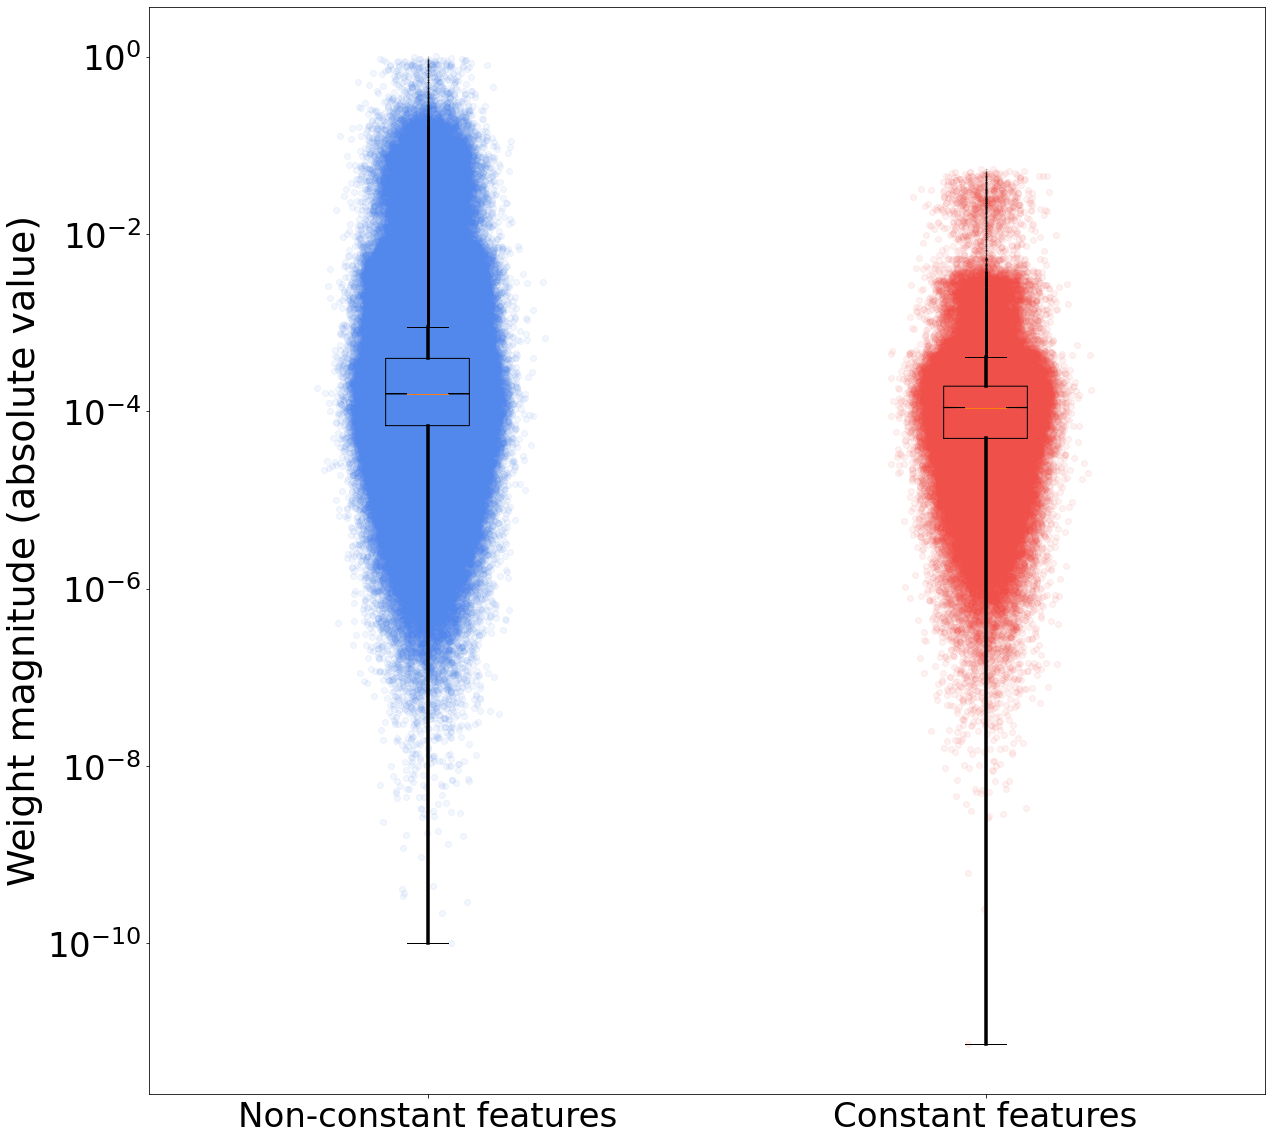

In [206]:
import matplotlib.pyplot as plt
import seaborn as sns

# Violin plot for feature weights
weights_constant_features_l1 = weights_del_l1[indices_constant_features].flatten()
weights_other_features_l1 = np.delete(weights_del_l1, indices_constant_features, axis=0).flatten()

assert len(weights_other_features_l1) + len(weights_constant_features_l1) == weights_del_l1.shape[0] * weights_del_l1.shape[1]

plt.rcParams['figure.figsize'] = [20, 20]

plt.yscale('log')

to_plot = [np.abs(weights_other_features_l1), np.abs(weights_constant_features_l1)]

colors = ["#5288eb", "#f0504a"]

# Source for plotting code: https://stackoverflow.com/questions/29779079/adding-a-scatter-of-points-to-a-boxplot-using-matplotlib
for i in [1,2]:
    y = to_plot[i - 1]
    
    # Add some random "jitter" to the x-axis
    x = np.random.normal(i, 0.04, size=len(y))
    
    plt.scatter(x, y, color=colors[i-1], alpha=0.075)

plt.boxplot(to_plot, flierprops={'marker': 'o', 'markersize': 0.5, 'alpha': 0.2}, notch='True', 
            whiskerprops = {'linewidth': 3.5, 'color': 'black'})
plt.xticks([1, 2], ["Non-constant features", "Constant features"], fontsize=34)
plt.yticks(fontsize=34)
plt.ylabel("Weight magnitude (absolute value)", fontsize=38)
plt.savefig('regularization.png')
plt.show()
plt.close()



/home/bianca/anaconda3/lib/python3.8/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)
/home/bianca/anaconda3/lib/python3.8/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)


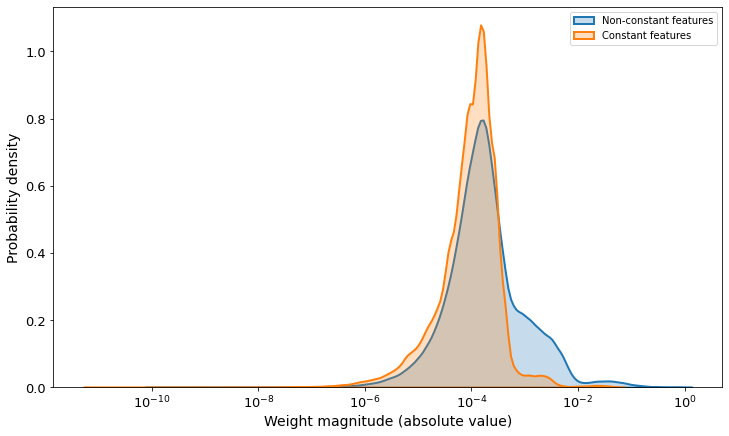

In [207]:
plt.rcParams['figure.figsize'] = [12, 7]

plt.xscale('log')
sns.distplot(np.abs(weights_other_features_l1), hist=False, kde = True, 
             kde_kws = {'shade': True, 'linewidth': 2}, 
             label = "Non-constant features")
sns.distplot(np.abs(weights_constant_features_l1), hist=False, kde = True, 
             kde_kws = {'shade': True, 'linewidth': 2}, 
             label = "Constant features")
plt.xlabel("Weight magnitude (absolute value)", fontsize=14)
plt.ylabel("Probability density", fontsize=14)
plt.xticks(fontsize=13)
plt.yticks(fontsize=13)
plt.legend()
plt.savefig('regularization.svg')

## Re-training the deletion model without constant features

We now re-use most of the code from the Lindel GitHub to train the deletion model by removing all constant features from the training data (and at evaluation also from the test data). We train for both L1 and L2 regularization.

In [208]:
# This code is mostly taken from LR_deletion.py
num_sequence_features = 384
feature_size = len(features) + num_sequence_features

# Without this if statement, this sometimes throws an error
# It can happen if you run cells in different order, or re-run some cells
if not (isinstance(Lindel_training, np.ndarray)):
    Lindel_training = Lindel_training.to_numpy()
    
Lindel_training = Lindel_training[:,1:].astype('float32')
X = Lindel_training[:,:feature_size]
y = Lindel_training[:, feature_size:]

np.random.seed(121)

# Shuffle data
idx = np.arange(len(y))
np.random.shuffle(idx)
X, y = X[idx], y[idx]

train_size = 3900
valid_size = 450 

x_train,x_valid = [],[]
y_train,y_valid = [],[]

# Create training set with 3900 samples
for i in range(train_size):
    # Check that labels for each sample sum up to at most 1
    if 1> sum(y[i,:536])> 0 :
        # Normalize (probability distribution)
        y_train.append(y[i,:536]/sum(y[i,:536]))
        x_train.append(X[i])

# Add remaining samples from the dataset to the validation set
for i in range(train_size,len(idx)):
    if 1> sum(y[i,:536])>0 : 
        y_valid.append(y[i,:536]/sum(y[i,:536]))
        x_valid.append(X[i])

# Convert to numpy arrays
x_train,x_valid = np.array(x_train),np.array(x_valid)
y_train,y_valid = np.array(y_train),np.array(y_valid)

In [209]:
from tqdm import tqdm_notebook as tqdm

from keras.callbacks import EarlyStopping
from keras.layers import Dense, Input, Flatten
from keras.models import Sequential, load_model
from keras.regularizers import l2, l1

# Define useful functions
def mse(x, y):
    return ((x-y)**2).mean()

def train_deletion_model(x_valid, x_train, y_valid, y_train, removed_feature_indices, filename, regularizer="l1"):
    lambdas = 10 ** np.arange(-10, -1, 0.1)
    errors = []
    
    # Remove features from x_train and x_valid
    x_train = np.delete(x_train, removed_feature_indices, 1)
    x_valid = np.delete(x_valid, removed_feature_indices, 1)
    
    size_input = x_train.shape[1]
    
    for l in tqdm(lambdas):
        np.random.seed(0)
        model = Sequential()

        if regularizer == "l1":
            model.add(Dense(536,  activation='softmax', input_shape=(size_input,), kernel_regularizer=l1(l)))
        else:
            model.add(Dense(536,  activation='softmax', input_shape=(size_input,), kernel_regularizer=l2(l)))
            
        model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['mse'])

        model.fit(x_train, y_train, epochs=100, validation_data=(x_valid, y_valid), 
                  callbacks=[EarlyStopping(patience=1)], verbose=0)

        y_hat = model.predict(x_valid)
        errors.append(mse(y_hat, y_valid))
     
    np.save('mse_' + regularizer + '_del.npy',errors)
    
    # Final model
    # Find best lambda for L1 regularization
    l = lambdas[np.argmin(errors)]
    np.random.seed(0)

    model = Sequential()
    if regularizer == "l1":
        model.add(Dense(536,  activation='softmax', input_shape=(size_input,), kernel_regularizer=l1(l)))
    else:
        model.add(Dense(536,  activation='softmax', input_shape=(size_input,), kernel_regularizer=l2(l)))
        
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['mse'])
    history = model.fit(x_train, y_train, epochs=100, validation_data=(x_valid, y_valid), 
          callbacks=[EarlyStopping(patience=1)], verbose=0)
        
    model.save(filename)
    
    return model, errors

In [210]:
import os

# Only train if the model file is not available
if not (os.path.exists('l1_no_constant_features_del.h5')):
    # L1 - model without constant features
    model_l1, errors_l1 = train_deletion_model(x_valid, x_train, y_valid, y_train, 
                                               indices_constant_features, 
                                               "l1_no_constant_features_del.h5", "l1")

if not (os.path.exists('l2_no_constant_features_del.h5')):
    # L2 - model without constant features
    model_l2, errors_l2 = train_deletion_model(x_valid, x_train, y_valid, y_train,
                                               indices_constant_features,
                                               "l2_no_constant_features_del.h5", "l2")

In [211]:
# Load new trained model weights 
model_l1_fewer_features = keras.models.load_model("l1_no_constant_features_del.h5")
weights_l1_fewer_features, bias_l1_fewer_features = model_l1_fewer_features.get_weights()[0], model_l1_fewer_features.get_weights()[1]

model_l2_fewer_features = keras.models.load_model("l2_no_constant_features_del.h5")
weights_l2_fewer_features, bias_l2_fewer_features = model_l2_fewer_features.get_weights()[0], model_l2_fewer_features.get_weights()[1]

In [212]:
# Load old model (fully, with deletion, indel and insertion)
model_del = keras.models.load_model("../data/L1_del.h5")
model_ins = keras.models.load_model("../data/L1_ins.h5")
model_indels = keras.models.load_model("../data/L2_indel.h5")

old_weights = [model_indels.get_weights()[0], model_indels.get_weights()[1],
               model_del.get_weights()[0], model_del.get_weights()[1],
               model_ins.get_weights()[0], model_ins.get_weights()[1]]

# Define all weights for new model
# Only replace deletion weights by those from the model trained with fewer features
new_weights = [model_indels.get_weights()[0], model_indels.get_weights()[1],
               weights_l1_fewer_features, bias_l1_fewer_features,
               model_ins.get_weights()[0], model_ins.get_weights()[1]]

## Evaluation: L1 regularized Lindel without constant features

We rewrite the original Lindel prediction function to include a step in which we remove constant features from the test sequence encoding. We then plot the performance of this model against the original Lindel model.

In [213]:
# Load labels and features
label, rev_index, features = pkl.load(open("../data/feature_index_all.pkl", "rb"))
feature_size = len(features) + 384

# Load test data with full 60 bp sequences
test_data  = np.loadtxt("../data/Lindel_test_with_full_seqs.txt", delimiter='\t', dtype='str')
data = test_data[:, 1:].astype('float32')
y = data[:, feature_size:]

model_preq = pkl.load(open("../data/model_prereq.pkl", 'rb'))
label,rev_index,features,frame_shift = model_preq

In [214]:
from Predictor import gen_indel, gen_cmatrix, onehotencoder, create_feature_array, softmax

# Slightly modified the original prediction function, to remove constant features from the test set
# We get constant features by their indices in the training set (we do NOT compute constant features across the test set)
def gen_prediction(seq, wb, prereq, features_to_remove=None, mca=None):
    '''Generate the prediction for all classes, redundant classes will be combined'''
    pam = {'AGG':0,'TGG':0,'CGG':0,'GGG':0}
    guide = seq[13:33]
    if seq[33:36] not in pam:
        return (None, None)
    
    w1,b1,w2,b2,w3,b3 = wb
    label,rev_index,features,frame_shift = prereq
    
    indels = gen_indel(seq,30) 
    input_indel = onehotencoder(guide)
    input_ins   = onehotencoder(guide[-6:])
    input_del   = np.concatenate((create_feature_array(features,indels),input_indel),axis=None)
    
    # Remove features from deletion model
    if features_to_remove is not None:
        input_del = np.delete(input_del, features_to_remove)
        
    # Apply MCA
    if mca is not None:
        input_del = mca.transform(np.array([input_del]))
        input_del = input_del.to_numpy()[0]
    # Generate c-matrix: combine redundant classes
    cmax = gen_cmatrix(indels,label)
    
    # Generate predictions
    dratio, insratio = softmax(np.dot(input_indel,w1)+b1)
    ds  = softmax(np.dot(input_del,w2)+b2)
    ins = softmax(np.dot(input_ins,w3)+b3)
    y_hat = np.concatenate((ds*dratio,ins*insratio),axis=None) * cmax
    
    return (y_hat,np.dot(y_hat,frame_shift))

In [215]:
# Initialize an empty array to store predicted frameshifts
predicted_frameshift_old, predicted_frameshift_new = [], []
# Initialize an empty predictions array
predictions_old, predictions_new = [], []
    
for i, sample in enumerate(test_data):
    # Get the sequence
    sequence = sample[0]      

    # Generate predictions
    pred_old, fs_old = gen_prediction(sequence, old_weights, model_preq)
    pred_new, fs_new = gen_prediction(sequence, new_weights, model_preq, indices_constant_features)

    # Store prediction and predicted frameshift
    predictions_old.append(pred_old)
    predicted_frameshift_old.append(fs_old)
    
    predictions_new.append(pred_new)
    predicted_frameshift_new.append(fs_new)

In [216]:
# Get the actual frameshifts
actual_frameshift = np.dot(y,frame_shift).tolist()

In [238]:
from scipy import stats

for i, pfs_old in enumerate(predicted_frameshift_old): 
    if pfs_old is None:
        predicted_frameshift_old.pop(i)
        predicted_frameshift_new.pop(i)
        actual_frameshift.pop(i)

# Calculate the frameshift MSE
mse_old = np.mean((np.array(actual_frameshift) - np.array(predicted_frameshift_old))**2)
mse_new = np.mean((np.array(actual_frameshift) - np.array(predicted_frameshift_new))**2)
# Keep 3 decimal places
mse_old, mse_new = round(mse_old, 4), round(mse_new, 4)
# Calculate pearson correlation
pearson_old = stats.pearsonr(actual_frameshift, predicted_frameshift_old)
pearson_new = stats.pearsonr(actual_frameshift, predicted_frameshift_new)
# Keep 3 decimal places
pearson_old, pearson_new = round(pearson_old[0], 3), round(pearson_new[0], 3)

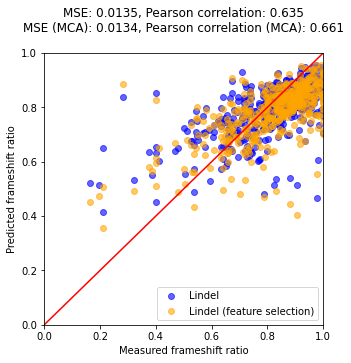

In [239]:
# PLOT FRAMESHIFT
# Plot the actual vs. predicted frameshifts
def plot_frameshift(actual_frameshift, predicted_frameshifts, labels, mses, correlations, filename):
    # Include in the plot the mse and pearson correlation
    plt.rcParams['figure.figsize'] = [5, 5]
    plt.title("MSE: {}, Pearson correlation: {}\nMSE (MCA): {}, Pearson correlation (MCA): {}\n".format(mses[0], correlations[0], mses[1], correlations[1]))
    plt.plot([0, 1], [0, 1], transform=plt.gca().transAxes, color = "red")
    plt.scatter(actual_frameshift, predicted_frameshifts[0], color='blue', alpha=0.6, label=labels[0])
    plt.scatter(actual_frameshift, predicted_frameshifts[1], color="orange", alpha=0.6, label=labels[1])
    plt.xlabel("Measured frameshift ratio")
    plt.ylabel("Predicted frameshift ratio")
    plt.legend()
    plt.xlim(0, 1)
    plt.ylim(0, 1)
    plt.savefig(filename)
    plt.show()
    
    
plot_frameshift(actual_frameshift, [predicted_frameshift_old, predicted_frameshift_new], 
                ['Lindel', 'Lindel (feature selection)'], [mse_old, mse_new], 
                [pearson_old, pearson_new], "fs_no_constant.svg")

In [219]:
mses_old, mses_new = [], []
count_invalid = 0
invalid_seqs = set()

# Calculate MSEs
for i, (prediction_old, prediction_new) in enumerate(zip(predictions_old, predictions_new)):
    if prediction_old is None:
        count_invalid += 1
        invalid_seqs.add(test_data[i, 0])
        continue
    
    mses_old.append(np.mean((prediction_old - y[i])**2))
    mses_new.append(np.mean((prediction_new - y[i])**2))

print("Invalid guide sequences:", count_invalid)
print("Invalid sequences, not found under 70k seq design", invalid_seqs)
    
# Print the mean MSE
print("Mean MSE: {}".format(np.mean(mses_old)))
print("Mean MSE (feature selection): {}".format(np.mean(mses_new)))
    
# Load aggregate model predictions
aggregate_test_predictions = pkl.load(open("../data/aggregate_model_test_predictions.pkl", "rb"))

dummy_mses = []
for i in range(len(y)):
    dmse = np.mean((aggregate_test_predictions[i] - y[i])**2)
    dummy_mses.append(dmse)
    
# Divide mses and dummy_mses by 10^-3 to make the plot more readable
dummy_mses = np.array(dummy_mses)/10**-3
mses_old, mses_new = np.array(mses_old)/10**-3, np.array(mses_new)/10**-3

Invalid guide sequences: 10
Invalid sequences, not found under 70k seq design {'CCGTTCGTCATTACCCATTC', 'CGTTTCCGCTTGTTGATATC', 'CCATCGTAGTGTGGTGATCG', 'CGCGTACTACCGCTGTACGT', 'TCGCGGAACGGAACAACGAA', 'ATCGCGTCGGCTAGTAACCG', 'CCGCCCTTTCGTGTGGTCTC', 'ATCACCCGGAGTGTCGGTAT', 'ATCGCTGACTAGTCGCTGGT', 'CTAGTTCAATGGCGGCTGTT'}
Mean MSE: 0.00015513946239739782
Mean MSE (feature selection): 0.0001472775124573788


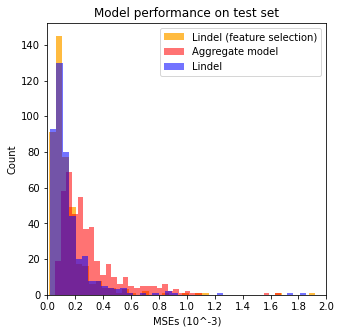

In [220]:
import seaborn as sns

# PLOT MSE HISTOGRAM
def plot_mse_histogram(mses_new, dummy_mses, mses_old, filename, labels, title='Model performance on test set'):
    sns.histplot(mses_new, bins=40, color='orange', label=labels[0], alpha=0.75, edgecolor=None)
    sns.histplot(dummy_mses, bins=40, color='red', label=labels[1], alpha=0.55, edgecolor=None)
    sns.histplot(mses_old, bins=40, color='blue', label=labels[2], alpha=0.55, edgecolor=None)
    plt.xticks(np.arange(0, 3, 0.2))
    # Set to log scale
    plt.legend()
    plt.xlabel("MSEs (10^-3)")
    plt.xlim(0.0, 2.0)
    plt.title(title)
    plt.savefig(filename)
    plt.show()
    
plot_mse_histogram(mses_new, dummy_mses, mses_old, 'mses_no_constant.svg', 
                   ['Lindel (feature selection)', 'Aggregate model', 'Lindel'])

## MCA (Multiple Correspondence Analysis)

Now we perform MCA to further reduce the dimensionality of the Lindel dataset, after removing constant features. We use the implementation made available by the Prince library.

In [221]:
import prince

In [222]:
x_train_no_constant_features = np.delete(x_train, indices_constant_features, 1)
x_valid_no_constant_features = np.delete(x_valid, indices_constant_features, 1)

all_x_no_constant_features = np.concatenate((x_train_no_constant_features, x_valid_no_constant_features))

In [223]:
# Train multiple MCA models
num_components = [250, 500, 750, 1000, 1500, 2000]
mca_models = dict()

file_with_models = 'mca_models.pkl'
if not (os.path.exists(file_with_models)):
    for n in num_components:
        print(n)
        mca = prince.MCA(n_components=n,
                     n_iter=100,
                     copy=True,
                     check_input=True,
                     engine='sklearn',
                     random_state=42)
    
        # Fit on training + validation set
        mca = mca.fit(all_x_no_constant_features)
    
        mca_models[n] = mca
    
    with open(file_with_models, 'wb') as f:
        pkl.dump(mca_models, f, protocol=pkl.HIGHEST_PROTOCOL)
    f.close()
else:
    with open(file_with_models, 'rb') as f:
        mca_models = pkl.load(f)
    f.close()
  

for n in num_components:
    mca = mca_models[n]
    
    model_file = 'l1_mca' + str(n) + '_del.h5'
    
    if not (os.path.exists(model_file)):
        x_train_transformed = mca.transform(x_train_no_constant_features)
        x_valid_transformed = mca.transform(x_valid_no_constant_features)
        model_mca_l1, errors_mca_l1 = train_deletion_model(x_valid_transformed, x_train_transformed, 
                                                           y_valid, y_train, [], model_file,
                                                           regularizer="l1")

Now we compute summary statistics for all MCA models and select the one with the best MSE.

In [237]:
# Initialize dictionaries to store predictions
mca_predictions = dict()
mca_fs_predictions = dict()

# Initialize dictionaries where keys represent the number of components and values are metrics
# Store MSEs per prediction
mca_mses = dict()
#Store MSEs per model
mca_model_mses = dict()
# Store frameshift MSEs and correlations
mca_fs_mses = dict()
mca_fs_correlations = dict()

for n in num_components:
    mca_mses[n] = []
    mca_predictions[n] = []
    mca_fs_predictions[n] = []

for n in num_components:  
    model_file = 'l1_mca' + str(n) + '_del.h5'

    # Load model and weights
    model_mca = keras.models.load_model(model_file)
    weights_del_mca, bias_del_mca = model_mca.get_weights()[0], model_mca.get_weights()[1]

    # Replace deletion model weights with the MCA model weights
    weights_mca = [model_indels.get_weights()[0], model_indels.get_weights()[1],
                   weights_del_mca, bias_del_mca,
                   model_ins.get_weights()[0], model_ins.get_weights()[1]]
    
    for i, sample in enumerate(test_data):
        # Get the sequence
        sequence = sample[0]      

        # Generate predictions
        # We also still remove constant features
        pred_mca, fs_mca = gen_prediction(sequence, weights_mca, model_preq, indices_constant_features, mca_models[n])
        
        mca_predictions[n].append(pred_mca)
        mca_fs_predictions[n].append(fs_mca)
    
    for i, prediction_mca in enumerate(mca_predictions[n]):
        if prediction_mca is None:
            continue
            
        mca_mses[n].append(np.mean((prediction_mca - y[i])**2))
              
    for i, pfs in enumerate(mca_fs_predictions[n]): 
        if pfs is None:
            mca_fs_predictions[n].pop(i)
        
    mca_model_mses[n] = np.mean(mca_mses[n])
    mca_fs_mses[n] = np.mean((np.array(actual_frameshift) - np.array(mca_fs_predictions[n]))**2)
    mca_fs_correlations[n] = stats.pearsonr(actual_frameshift, mca_fs_predictions[n])[0]
  
print(mca_model_mses)
print(mca_fs_mses)
print(mca_fs_correlations)
best_model, best_mse = min(mca_model_mses.items(), key=lambda x: x[1])
print("Best model is MCA with " + str(best_model) + " components, and MSE " + str(best_mse))
print("Mean MSE of model with no constant features: ", np.mean(mses_new) * 10 ** (-3))
print("Mean MSE of original Lindel model: ", np.mean(mses_old) * 10 ** (-3))
    

{250: 0.00017025200668224766, 500: 0.00016042613544007525, 750: 0.00015562145268343516, 1000: 0.0001504187127751872, 1500: 0.0001473738092188327, 2000: 0.00014706750469577467}
{250: 0.0160256780976349, 500: 0.01476683124632224, 750: 0.014628774511986384, 1000: 0.013878932019536015, 1500: 0.01329773254859895, 2000: 0.013321228783836434}
{250: 0.5894456779933697, 500: 0.6264647581240709, 750: 0.6323538461410952, 1000: 0.6603568868782783, 1500: 0.6766116638754612, 2000: 0.6790631449087366}
Best model is MCA with 2000 components, and MSE 0.00014706750469577467
Mean MSE of model with no constant features:  0.0001472775124573788
Mean MSE of original Lindel model:  0.00015513946239739784


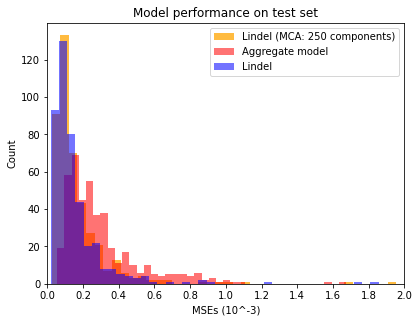

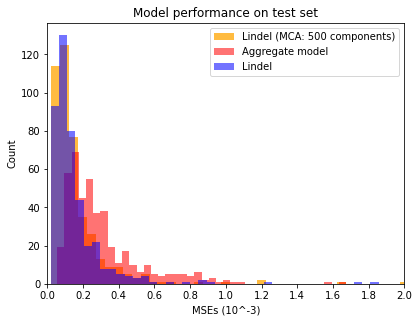

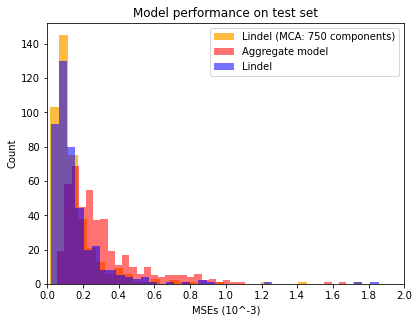

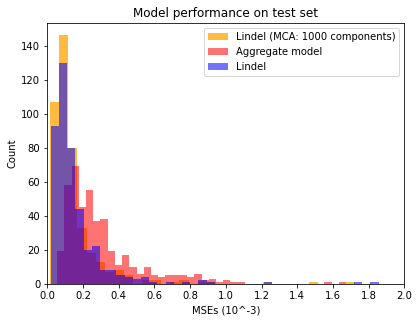

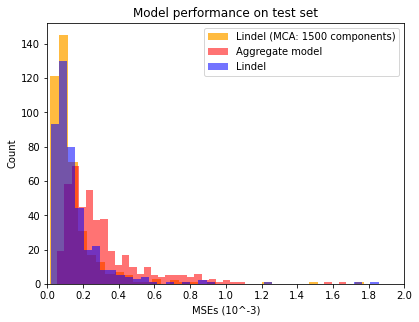

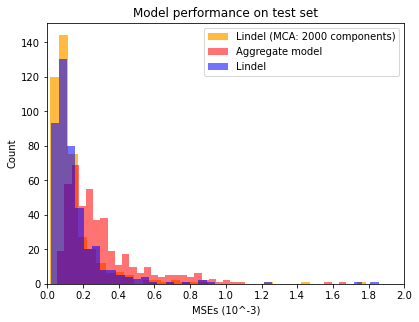

In [240]:
for n in num_components:
    plt.rcParams['figure.figsize'] = [6.4, 4.8]
    plot_mse_histogram(np.array(mca_mses[n]) * (10 ** 3), dummy_mses, mses_old, 'mses_mca_' + str(n) + '.svg', 
                   ['Lindel (MCA: ' + str(n) + ' components)', 'Aggregate model', 'Lindel'])

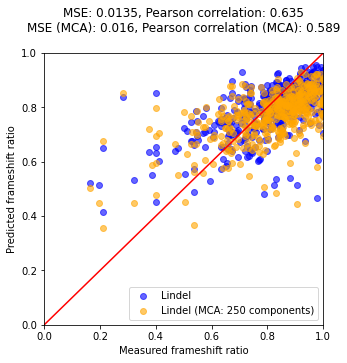

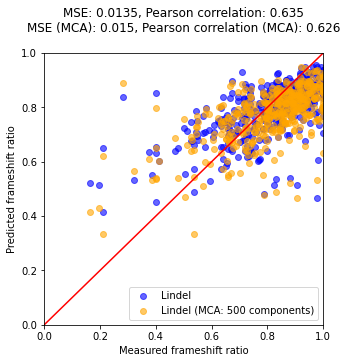

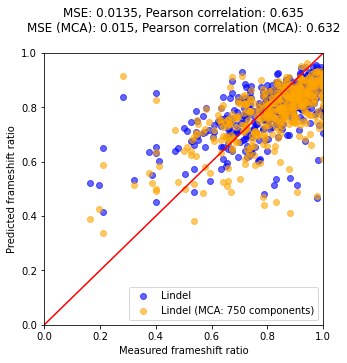

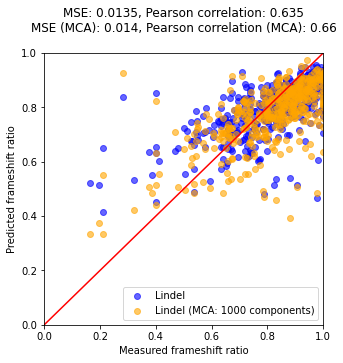

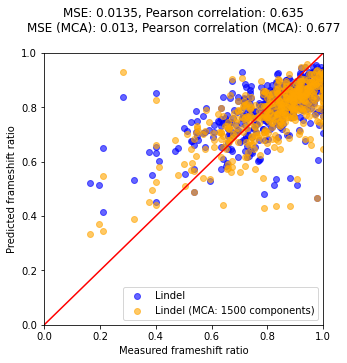

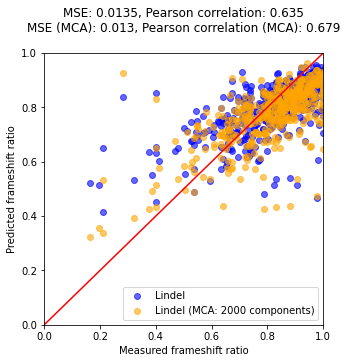

In [243]:
for n in num_components:
    plot_frameshift(actual_frameshift, [predicted_frameshift_old, mca_fs_predictions[n]], 
                ['Lindel', 'Lindel (MCA: ' + str(n) + ' components)'], [mse_old, round(mca_fs_mses[n], 3)], 
                [pearson_old, round(mca_fs_correlations[n], 3)], "fs_mca" + str(n) + ".svg")